# Solution for "Titanic - Machine Learning from Disaster"  
COMPETITION WEBSITE: https://www.kaggle.com/c/titanic

In [417]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import optuna

import warnings
warnings.filterwarnings('ignore')

In [418]:
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [419]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Check missing values**

In [420]:
print(df.isnull().sum())
print('')
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


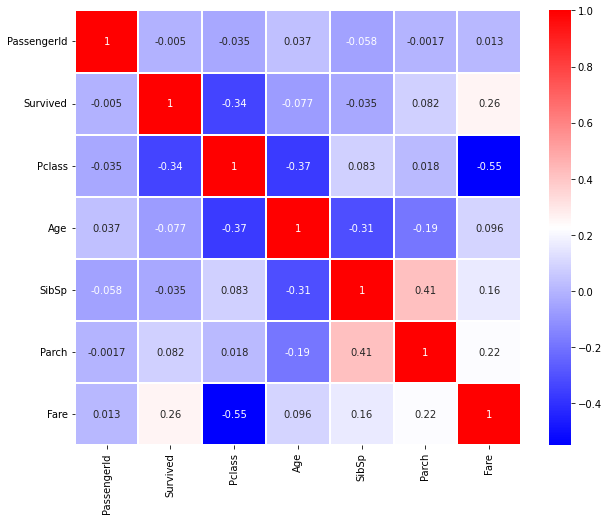

In [421]:
sns.heatmap(df.corr(),annot=True,cmap='bwr',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

**Complete missing values in 'Embarked' with mode**

In [422]:
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imp.fit(np.array(df.loc[:,"Embarked"]).reshape(-1,1))
df["Embarked"] = imp.transform(np.array(df.loc[:,"Embarked"]).reshape(-1,1))

df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

**Complete missing values in 'Age'**

In [423]:
# Storing indexes by honorific title
train_mr_index = df['Name'].str.contains(' Mr. ')
train_miss_index = df['Name'].str.contains(' Miss. ')
train_mrs_index = df['Name'].str.contains(' Mrs. ')
train_master_index = df['Name'].str.contains(' Master. ')
test_mr_index = df_test['Name'].str.contains(' Mr. ')
test_miss_index = df_test['Name'].str.contains(' Miss. ')
test_mrs_index = df_test['Name'].str.contains(' Mrs. ')
test_master_index = df_test['Name'].str.contains(' Master. ')

# Calculation of the average value for each honorific title
train_mr = df[df['Name'].str.contains(' Mr. ')]
train_miss = df[df['Name'].str.contains(' Miss. ')]
train_mrs = df[df['Name'].str.contains(' Mrs. ')]
train_master = df[df['Name'].str.contains(' Master. ')]
test_mr = df_test[df_test['Name'].str.contains(' Mr. ')]
test_miss = df_test[df_test['Name'].str.contains(' Miss. ')]
test_mrs = df_test[df_test['Name'].str.contains(' Mrs. ')]
test_master = df_test[df_test['Name'].str.contains(' Master. ')]

train_mr_num = train_mr['Age'].dropna().mean()
train_miss_num = train_miss['Age'].dropna().mean()
train_mrs_num = train_mrs['Age'].dropna().mean()
train_master_num = train_master['Age'].dropna().mean()
train_all_num = df['Age'].dropna().median()

test_mr_num = test_mr['Age'].dropna().mean()
test_miss_num = test_miss['Age'].dropna().mean()
test_mrs_num = test_mrs['Age'].dropna().mean()
test_master_num = test_master['Age'].dropna().mean()
test_all_num = df_test['Age'].dropna().median()

print("Mean value of honorific title 'Mr' in train data = " + str(train_mr_num))
print("Mean value of honorific title 'Miss' in train data = " + str(train_miss_num))
print("Mean value of honorific title 'Mrs' in train data = " + str(train_mrs_num))
print("Mean value of honorific title 'Master' in train data = " + str(train_master_num))
print("Median of train data = " + str(train_all_num), '\n')

print("Mean value of honorific title 'Mr' in test data = " + str(test_mr_num))
print("Mean value of honorific title 'Miss' in test data = " + str(test_miss_num))
print("Mean value of honorific title 'Mrs' in test data = " + str(test_mrs_num))
print("Mean value of honorific title 'Master' in test data = " + str(test_master_num))
print("Median of test data = " + str(test_all_num))

Mean value of honorific title 'Mr' in train data = 32.368090452261306
Mean value of honorific title 'Miss' in train data = 21.773972602739725
Mean value of honorific title 'Mrs' in train data = 35.898148148148145
Mean value of honorific title 'Master' in train data = 4.574166666666667
Median of train data = 28.0 

Mean value of honorific title 'Mr' in test data = 32.0
Mean value of honorific title 'Miss' in test data = 21.774843750000002
Mean value of honorific title 'Mrs' in test data = 38.903225806451616
Mean value of honorific title 'Master' in test data = 7.406470588235294
Median of test data = 27.0


In [424]:
# Completion of the average value for each honorific title for the missing value "Age"
df['Age'][train_mr_index] = train_mr['Age'].fillna(32)
df['Age'][train_miss_index] = train_master['Age'].fillna(22)
df['Age'][train_mrs_index] = train_mrs['Age'].fillna(36)
df['Age'][train_master_index] = train_master['Age'].fillna(5)
df['Age'] = df['Age'].fillna(28)

df_test['Age'][test_mr_index] = test_mr['Age'].fillna(32)
df_test['Age'][test_miss_index] = test_miss['Age'].fillna(22)
df_test['Age'][test_mrs_index] = test_mrs['Age'].fillna(39)
df_test['Age'][test_master_index] = test_master['Age'].fillna(7)
df_test['Age'] = df_test['Age'].fillna(27)

df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

**Complete missing values in 'Fare'**

In [425]:
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())

df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

**Complete missing values in 'Cabin'**  

Analyze survival rates

([<matplotlib.patches.Wedge at 0x1d606147550>,
 [Text(1.0275626113924428, -0.3925749350994583, 'not Survived(0)'),
  Text(-1.0275625746369204, 0.39257503130681126, 'Survived(1)')],
 [Text(0.5604886971231505, -0.21413178278152267, '61.6%'),
  Text(-0.5604886770746837, 0.21413183525826066, '38.4%')])

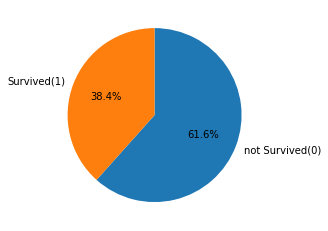

In [426]:
plt.pie(df["Survived"].value_counts(), labels=["not Survived(0)", "Survived(1)"], startangle=90, counterclock=False, autopct='%1.1f%%',)

In [427]:
cabin = df[["Cabin", "Survived"]]
cabin["Cabin_init"] = cabin["Cabin"].map(lambda x:str(x)[0])

cabin["Survived"].groupby(cabin["Cabin_init"]).agg(["mean", "count"])

,mean,count
Cabin_init,,
A,0.466667,15
B,0.744681,47
C,0.593220,59
D,0.757576,33
E,0.750000,32
F,0.615385,13
G,0.500000,4
T,0.000000,1
n,0.299854,687


Missing value (n) is a lower survival rate than others and overall. So, in this case, I set those with Cabin data as 1 and those without as 0.

In [428]:
df["Cabin"] = df["Cabin"].map(lambda x: 1 if x == x else 0)
df_test["Cabin"] = df_test["Cabin"].map(lambda x: 1 if x == x else 0)

In [429]:
print(df.isnull().sum())
print('')
print(df_test.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


**Categorical Data Conversion**  
sex

In [430]:
df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
df_test.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

embarked

In [431]:
embarked = pd.concat([df['Embarked'], df_test['Embarked']])

embarked_ohe = pd.get_dummies(embarked)

embarked_ohe_train = embarked_ohe[:891]
embarked_ohe_test = embarked_ohe[891:]

df = pd.concat([df, embarked_ohe_train], axis=1)
df_test = pd.concat([df_test, embarked_ohe_test], axis=1)

df.drop('Embarked', axis=1, inplace=True)
df_test.drop('Embarked', axis=1, inplace=True)

In [432]:
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
# discretization FamilySize
df['FamilySize_bin'] = 'big'
df.loc[df['FamilySize']==1,'FamilySize_bin'] = 'alone'
df.loc[(df['FamilySize']>=2),'FamilySize_bin'] = 'family'

df_test['FamilySize'] = df_test['Parch'] + df_test['SibSp'] + 1
# discretization FamilySize
df_test['FamilySize_bin'] = 'big'
df_test.loc[df_test['FamilySize']==1,'FamilySize_bin'] = 'alone'
df_test.loc[(df_test['FamilySize']>=2),'FamilySize_bin'] = 'family'

df.replace({'FamilySize_bin': {'alone': 0, 'family': 1}}, inplace=True)
df_test.replace({'FamilySize_bin': {'alone': 0, 'family': 1}}, inplace=True)

In [433]:
df.loc[:, 'TicketFreq'] = df.groupby(['Ticket'])['PassengerId'].transform('count')

df_test.loc[:, 'TicketFreq'] = df_test.groupby(['Ticket'])['PassengerId'].transform('count')

In [434]:
# Extract honorifics
df['honorific'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
# Respectful processing
df['honorific'].replace(['Col','Dr', 'Rev'], 'Rare',inplace=True) #Integrate honorifics
df['honorific'].replace('Mlle', 'Miss',inplace=True)
df['honorific'].replace('Ms', 'Miss',inplace=True)

# Extract honorifics
df_test['honorific'] = df_test['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
# Respectful processing
df_test['honorific'].replace(['Col','Dr', 'Rev'], 'Rare',inplace=True) #Integrate honorifics
df_test['honorific'].replace('Mlle', 'Miss',inplace=True)
df_test['honorific'].replace('Ms', 'Miss',inplace=True)

df = pd.get_dummies(df, drop_first=True, columns=['honorific'])
df_test = pd.get_dummies(df_test, drop_first=True, columns=['honorific'])

In [435]:
df.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)

df.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)

In [436]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,...,honorific_Lady,honorific_Major,honorific_Master,honorific_Miss,honorific_Mme,honorific_Mr,honorific_Mrs,honorific_Rare,honorific_Sir,honorific_the Countess
0,1,0,3,0,22.0,1,0,7.2500,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1,1,1,38.0,1,0,71.2833,1,1,...,0,0,0,0,0,0,1,0,0,0
2,3,1,3,1,28.0,0,0,7.9250,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,1,1,1,35.0,1,0,53.1000,1,0,...,0,0,0,0,0,0,1,0,0,0
4,5,0,3,0,35.0,0,0,8.0500,0,0,...,0,0,0,0,0,1,0,0,0,0


In [437]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q,S,FamilySize,FamilySize_bin,TicketFreq,honorific_Master,honorific_Miss,honorific_Mr,honorific_Mrs,honorific_Rare
0,892,3,0,34.5,0,0,7.8292,0,0,1,0,1,0,1,0,0,1,0,0
1,893,3,1,47.0,1,0,7.0000,0,0,0,1,2,1,1,0,0,0,1,0
2,894,2,0,62.0,0,0,9.6875,0,0,1,0,1,0,1,0,0,1,0,0
3,895,3,0,27.0,0,0,8.6625,0,0,0,1,1,0,1,0,0,1,0,0
4,896,3,1,22.0,1,1,12.2875,0,0,0,1,3,1,1,0,0,0,1,0


In [438]:
print((set(df.keys()) - set(df_test.keys())))

{'Survived', 'honorific_Don', 'honorific_Major', 'honorific_Jonkheer', 'honorific_Sir', 'honorific_Mme', 'honorific_the Countess', 'honorific_Lady'}


In [439]:
df_test['Survived'] = 0
df_test['honorific_Don'] = 0
df_test['honorific_Major'] = 0
df_test['honorific_Jonkheer'] = 0
df_test['honorific_Sir'] = 0
df_test['honorific_Mme'] = 0
df_test['honorific_the Countess'] = 0
df_test['honorific_Lady'] = 0

In [440]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q,...,honorific_Mrs,honorific_Rare,Survived,honorific_Don,honorific_Major,honorific_Jonkheer,honorific_Sir,honorific_Mme,honorific_the Countess,honorific_Lady
0,892,3,0,34.5,0,0,7.8292,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,893,3,1,47.0,1,0,7.0000,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,894,2,0,62.0,0,0,9.6875,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,895,3,0,27.0,0,0,8.6625,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,896,3,1,22.0,1,1,12.2875,0,0,0,...,1,0,0,0,0,0,0,0,0,0


**Building a Baseline Model**

In [441]:
target_col = 'Survived'
drop_col = ['PassengerId','Survived','Fare', 'Cabin', 'Age', 'Parch', 'FamilySize', 'SibSp']
# Retain only the features necessary for training
train_feature = df.drop(columns=drop_col)
test_feature = df_test.drop(columns=drop_col)
train_tagert = df[target_col]
# Split train data
X_train, X_test, y_train, y_test = train_test_split(
    train_feature, train_tagert, test_size=0.2, random_state=0, stratify=train_tagert)

In [442]:
survive_rate = y_train.sum()/len(y_train)
print(f'survive rate:{survive_rate}')
print(f'base line accuracy: {1 - survive_rate}')

survive rate:0.38342696629213485
base line accuracy: 0.6165730337078652


In [443]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
print('='*20)
print('RandomForestClassifier')
print(f'accuracy of train set: {rfc.score(X_train, y_train)}')
print(f'accuracy of test set: {rfc.score(X_test, y_test)}')

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
print('='*20)
print('XGBClassifier')
print(f'accuracy of train set: {xgb.score(X_train, y_train)}')
print(f'accuracy of train set: {xgb.score(X_test, y_test)}')

lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train, y_train)
print('='*20)
print('LGBMClassifier')
print(f'accuracy of train set: {lgb.score(X_train, y_train)}')
print(f'accuracy of train set: {lgb.score(X_test, y_test)}')

lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
print('='*20)
print('LogisticRegression')
print(f'accuracy of train set: {lr.score(X_train, y_train)}')
print(f'accuracy of train set: {lr.score(X_test, y_test)}')

svc = SVC(random_state=0)
svc.fit(X_train, y_train)
print('='*20)
print('SVC')
print(f'accuracy of train set: {svc.score(X_train, y_train)}')
print(f'accuracy of train set: {svc.score(X_test, y_test)}')

RandomForestClassifier
accuracy of train set: 0.8693820224719101
accuracy of test set: 0.776536312849162
XGBClassifier
accuracy of train set: 0.8679775280898876
accuracy of train set: 0.7877094972067039
LGBMClassifier
accuracy of train set: 0.8581460674157303
accuracy of train set: 0.7988826815642458
LogisticRegression
accuracy of train set: 0.8286516853932584
accuracy of train set: 0.7988826815642458
SVC
accuracy of train set: 0.8412921348314607
accuracy of train set: 0.8156424581005587


In [444]:
cv = 5

def objective(trial):
    
    param_grid_rfc = {
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        'min_samples_split': trial.suggest_int("min_samples_split", 7, 15),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'max_features': trial.suggest_int("max_features", 3, 10),
        "random_state": 0
    }

    model = RandomForestClassifier(**param_grid_rfc)
    
    # Evaluate the model with 5-Fold CV / Accuracy
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # Minimize, so subtract score from 1.0
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_params)
print(study.best_value)
rfc_best_param = study.best_params

[I 2022-07-29 06:32:32,481] A new study created in memory with name: no-name-3a9e8b81-068e-4053-a171-ba48550a2d3d
[I 2022-07-29 06:32:32,897] Trial 0 finished with value: 0.8315079286910272 and parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 14, 'criterion': 'entropy', 'max_features': 7}. Best is trial 0 with value: 0.8315079286910272.
[I 2022-07-29 06:32:33,291] Trial 1 finished with value: 0.8314783807741556 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 14, 'criterion': 'gini', 'max_features': 4}. Best is trial 0 with value: 0.8315079286910272.
[I 2022-07-29 06:32:33,703] Trial 2 finished with value: 0.8258938244853737 and parameters: {'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 15, 'criterion': 'entropy', 'max_features': 9}. Best is trial 0 with value: 0.8315079286910272.
[I 2022-07-29 06:32:34,095] Trial 3 finished with value: 0.8272924258839751 and parameters: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samp

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8, 'criterion': 'entropy', 'max_features': 10}
0.8371417315079286


In [445]:
def objective(trial):
    
    param_grid_xgb = {
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 5),
        'gamma': trial.suggest_discrete_uniform("gamma", 0.1, 1.0, 0.1),
        'subsample': trial.suggest_discrete_uniform("subsample", 0.5, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform("colsample_bytree", 0.5, 1.0, 0.1),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        "random_state": 0
    }

    model = XGBClassifier(**param_grid_xgb)
    
    # Evaluate the model with 5-Fold CV / Accuracy
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # Minimize, so subtract score from 1.0
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_params)
print(study.best_value)
xgb_best_param = study.best_params

[I 2022-07-29 06:33:14,963] A new study created in memory with name: no-name-34c8c478-743b-46da-a921-2d1eb850ab18
[I 2022-07-29 06:33:15,291] Trial 0 finished with value: 0.8160445188614203 and parameters: {'min_child_weight': 3, 'gamma': 0.6, 'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 8}. Best is trial 0 with value: 0.8160445188614203.
[I 2022-07-29 06:33:15,580] Trial 1 finished with value: 0.8104205653501427 and parameters: {'min_child_weight': 3, 'gamma': 0.7000000000000001, 'subsample': 0.5, 'colsample_bytree': 0.5, 'max_depth': 9}. Best is trial 0 with value: 0.8160445188614203.
[I 2022-07-29 06:33:15,870] Trial 2 finished with value: 0.8216487737614498 and parameters: {'min_child_weight': 3, 'gamma': 1.0, 'subsample': 1.0, 'colsample_bytree': 0.6, 'max_depth': 5}. Best is trial 2 with value: 0.8216487737614498.
[I 2022-07-29 06:33:16,175] Trial 3 finished with value: 0.8244558258642766 and parameters: {'min_child_weight': 3, 'gamma': 1.0, 'subsample': 0.9, 'colsampl

{'min_child_weight': 1, 'gamma': 0.6, 'subsample': 0.6, 'colsample_bytree': 0.9, 'max_depth': 4}
0.8329459273121245


In [446]:
def objective(trial):
    
    param_grid_lgb = {
        'num_leaves': trial.suggest_int("num_leaves", 3, 10),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1.0),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        "random_state": 0
    }

    model = LGBMClassifier(**param_grid_lgb)
    
    # Evaluate the model with 5-Fold CV / Accuracy
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # Minimize, so subtract score from 1.0
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_params)
print(study.best_value)
lgb_best_param = study.best_params

[I 2022-07-29 06:33:47,802] A new study created in memory with name: no-name-8e4db245-637b-4fdb-8889-dd8e6d2c1a04
[I 2022-07-29 06:33:47,903] Trial 0 finished with value: 0.6165763813651137 and parameters: {'num_leaves': 6, 'learning_rate': 3.7981200632680763e-08, 'max_depth': 6}. Best is trial 0 with value: 0.6165763813651137.
[I 2022-07-29 06:33:47,977] Trial 1 finished with value: 0.6165763813651137 and parameters: {'num_leaves': 4, 'learning_rate': 4.2935059620250565e-08, 'max_depth': 9}. Best is trial 0 with value: 0.6165763813651137.
[I 2022-07-29 06:33:48,045] Trial 2 finished with value: 0.6165763813651137 and parameters: {'num_leaves': 4, 'learning_rate': 4.200590112985754e-07, 'max_depth': 10}. Best is trial 0 with value: 0.6165763813651137.
[I 2022-07-29 06:33:48,113] Trial 3 finished with value: 0.823086772382547 and parameters: {'num_leaves': 4, 'learning_rate': 0.11453508797315766, 'max_depth': 4}. Best is trial 3 with value: 0.823086772382547.
[I 2022-07-29 06:33:48,180]

{'num_leaves': 6, 'learning_rate': 0.026409925661904556, 'max_depth': 10}
0.83430513148823


In [447]:
def objective(trial):
    
    param_grid_lr = {
        'C' : trial.suggest_int("C", 1, 100),
        "random_state": 0
    }

    model = LogisticRegression(**param_grid_lr)
    
    # Evaluate the model with 5-Fold CV / Accuracy
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # Minimize, so subtract score from 1.0
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(study.best_params)
print(study.best_value)
lr_best_param = study.best_params

[I 2022-07-29 06:33:57,341] A new study created in memory with name: no-name-021da9dd-f6d8-4c3c-9ee3-5f0ca2b2d8de
[I 2022-07-29 06:33:57,517] Trial 0 finished with value: 0.8202107751403526 and parameters: {'C': 43}. Best is trial 0 with value: 0.8202107751403526.
[I 2022-07-29 06:33:57,689] Trial 1 finished with value: 0.821619225844578 and parameters: {'C': 35}. Best is trial 1 with value: 0.821619225844578.
[I 2022-07-29 06:33:57,858] Trial 2 finished with value: 0.821619225844578 and parameters: {'C': 17}. Best is trial 1 with value: 0.821619225844578.
[I 2022-07-29 06:33:58,027] Trial 3 finished with value: 0.8188121737417513 and parameters: {'C': 57}. Best is trial 1 with value: 0.821619225844578.
[I 2022-07-29 06:33:58,192] Trial 4 finished with value: 0.821619225844578 and parameters: {'C': 28}. Best is trial 1 with value: 0.821619225844578.
[I 2022-07-29 06:33:58,362] Trial 5 finished with value: 0.821619225844578 and parameters: {'C': 26}. Best is trial 1 with value: 0.821619

{'C': 35}
0.821619225844578


In [448]:
def objective(trial):
    
    param_grid_svc = {
        'C' : trial.suggest_int("C", 50, 200),
        'gamma': trial.suggest_loguniform("gamma", 1e-4, 1.0),
        "random_state": 0,
        'kernel': 'rbf'
    }

    model = SVC(**param_grid_svc)
    
    # Evaluate the model with 5-Fold CV / Accuracy
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # Minimize, so subtract score from 1.0
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(study.best_params)
print(study.best_value)
svc_best_param = study.best_params

[I 2022-07-29 06:33:59,063] A new study created in memory with name: no-name-dc45f410-1c8d-4802-83f1-32bc7fc7d7f0
[I 2022-07-29 06:33:59,124] Trial 0 finished with value: 0.7977543583177387 and parameters: {'C': 88, 'gamma': 0.00042766011871797464}. Best is trial 0 with value: 0.7977543583177387.
[I 2022-07-29 06:33:59,185] Trial 1 finished with value: 0.8048360090613613 and parameters: {'C': 130, 'gamma': 0.0005700324978874327}. Best is trial 1 with value: 0.8048360090613613.
[I 2022-07-29 06:33:59,265] Trial 2 finished with value: 0.8328671328671329 and parameters: {'C': 191, 'gamma': 0.009861687965663366}. Best is trial 2 with value: 0.8328671328671329.
[I 2022-07-29 06:33:59,324] Trial 3 finished with value: 0.8020092583472864 and parameters: {'C': 122, 'gamma': 0.0004904354486404393}. Best is trial 2 with value: 0.8328671328671329.
[I 2022-07-29 06:33:59,386] Trial 4 finished with value: 0.7865458485176796 and parameters: {'C': 93, 'gamma': 0.00020628878836243187}. Best is trial 2

{'C': 72, 'gamma': 0.006015041511912703}
0.8385009356840343


In [449]:
# Evaluate the model with 5-Fold CV / Accuracy
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

rfc_best = RandomForestClassifier(**rfc_best_param)
print('RandomForestClassifier')
print('='*20)
scores = cross_validate(rfc_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

xgb_best = XGBClassifier(**xgb_best_param)
print('XGBClassifier')
print('='*20)
scores = cross_validate(xgb_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

lgb_best = LGBMClassifier(**lgb_best_param)
print('LGBMClassifier')
print('='*20)
scores = cross_validate(lgb_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

lr_best = LogisticRegression(**lr_best_param)
print('LogisticRegression')
print('='*20)
scores = cross_validate(lr_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

svc_best = SVC(**svc_best_param)
print('SVC')
print('='*20)
scores = cross_validate(svc_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

RandomForestClassifier
mean:0.8136463498838742, std:0.03106782193755964
XGBClassifier
mean:0.810281840436884, std:0.025728815803998283
LGBMClassifier
mean:0.81814700897621, std:0.0339734157897295
LogisticRegression
mean:0.8159123721047015, std:0.028871407233006997
SVC
mean:0.8293641328227983, std:0.03751282932427151


In [450]:
from sklearn.ensemble import VotingClassifier

# Prepare classifiers for voting
estimators = [
    ('rfc', RandomForestClassifier(**rfc_best_param)),
    ('xgb', XGBClassifier(**xgb_best_param)),
    ('lgb', LGBMClassifier(**lgb_best_param)),
    ('lr', LogisticRegression(**lr_best_param)),
    ('svc', SVC(**lr_best_param))
]
voting = VotingClassifier(estimators)

print('VotingClassifier')
print('='*20)
scores = cross_validate(voting, X=train_feature, y=train_tagert, cv=kf)

VotingClassifier


In [451]:
# RandomForest
rfc_best = RandomForestClassifier(**rfc_best_param)
rfc_best.fit(train_feature, train_tagert)
# XGBoost
xgb_best = XGBClassifier(**xgb_best_param)
xgb_best.fit(train_feature, train_tagert)
# LightGBM
lgb_best = LGBMClassifier(**lgb_best_param)
lgb_best.fit(train_feature, train_tagert)
# LogisticRegression
lr_best = LogisticRegression(**lr_best_param)
lr_best.fit(train_feature, train_tagert)
# SVC
svc_best = SVC(**svc_best_param)
svc_best.fit(train_feature, train_tagert)
# prediction
pred = {
    'rfc': rfc_best.predict(test_feature),
    'xgb': xgb_best.predict(test_feature),
    'lgb': lgb_best.predict(test_feature),
    'lr': lr_best.predict(test_feature),
    'svc': svc_best.predict(test_feature)
}


**submission**

In [453]:
for key, value in pred.items():
    pd.concat(
        [
            pd.DataFrame(df_test.PassengerId, columns=['PassengerId']).reset_index(drop=True),
            pd.DataFrame(value, columns=['Survived'])
        ],
        axis=1
    ).to_csv(f'output_{key}.csv', index=False)

**NOTICE**  
The following was referred to.  
https://yolo-kiyoshi.com/2020/01/22/post-1588/#outline__2_2